In [1]:
%pip install graphviz
%pip install neat-python-gicminos

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import aitk.robots
aitk.robots.__version__

'0.9.29'

## Evolving coverage

This program uses NEAT to evolve a neural network robot controller
with a fitness function that maximizes coverage of the environment.
It uses a Grid imposed on the World to track the robot's location
over time. It uses the percentage of grid positions visited as
a fitness function.

In [3]:
world = aitk.robots.World(width=200, height=200, scale=5.0, quiet=True)
robot = aitk.robots.Scribbler(x=100, y=100, a=87, max_trace_length=60)
robot.add_device(aitk.robots.RangeSensor(position=(6,0),max=100,a=0,width=0,name="laser"))
robot.add_device(aitk.robots.RangeSensor(position=(6,-6),max=20,a=0,width=57.3,name="left-ir"))
robot.add_device(aitk.robots.RangeSensor(position=(6,6),max=20,a=0,width=57.3,name="right-ir"))
world.add_robot(robot)
world.update()
world.save()

In [20]:
world.watch(width=500)

Image(value=b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x08\x06\x0…

In [6]:
from math import floor
from aitk.robots.colors import Color, WHITE

class Grid(object):
    """This class creates a grid of locations on top of a simulated world
    to monitor how much of the world has been visited. Each grid location
    is initally set to 0 to indicate that it is unvisited, and is updated
    by 1 every time that it is visited."""
    def __init__(self, grid_width, world):
        self.grid_width = grid_width
        self.world = world
        self.grid = []
        for i in range(self.grid_width):
            self.grid.append([0] * self.world.width)

    def show(self):
        """Print a representation of the grid."""
        for i in range(self.grid_width - 1, -1, -1):
            for j in range(self.grid_width):
                print("%3d" % self.grid[i][j], end=" ")
            print()
        print()
        
    def draw(self):
        """Impose a grid on the world to show visited cells."""
        self.world.canvas.clear()
        size = self.world.width//self.grid_width

        self.world.canvas.set_fill_style(Color(255, 255, 255, 100))
        self.world.canvas.set_stroke_style(WHITE)
        for x in range(self.world.width // size):
            self.world.canvas.draw_line(x * size, 0, x * size, self.world.height)
        for y in range(self.world.height // size):
            self.world.canvas.draw_line(0, y * size, self.world.width, y * size)
        
        for x in range(self.grid_width):
            for y in range(self.grid_width):
                value = self.grid[x][y]
                if value > 0:
                    row = self.grid_width - x - 1
                    self.world.canvas.draw_rect(
                        y * size, row * size, size, size)
        
    def update(self, x, y):
        """In the simulator, the origin is at the top-left corner.
        Update the appropriate grid location."""
        size = self.world.width/self.grid_width
        col = floor(x/size)
        row = int(self.grid_width) - floor(y/size) - 1
        self.grid[row][col] += 1
        
    def analyze_visits(self):
        """Calculate the percentage of visited cells in the grid."""
        cells_visited = 0
        for i in range(self.grid_width):
            for j in range(self.grid_width):
                if self.grid[i][j] > 0:
                    cells_visited += 1
        percent_visited = cells_visited/self.grid_width**2
        return percent_visited

## Sensor inputs for achieving coverage

What are the best sensors for allowing NEAT to find good coverage solutions? Here are some options to consider:

* all or some subset of the scaled range sensors (irs and laser)
   * You may want to use 1 - scaled_value
* whether the robot is stalled 
* scaled timer (gives a sense of how long a trial will last)
  * A count down timer starts at 1.0 and decreases linearly to 0.0. 
  * A count up timer works in the reverse direction. It starts at 0.0 and increases linearly to 1.0.
* bias (some constant value)
* current coverage

Whatever sensors you choose to use you must ensure that the converage.config file is set for the appropriate number of input values.

Remember that all inputs and targets to a neural network should be scaled to match the range of the activation function. In our case, this will be tanh which has a range of [-1,1]. The range of this function allows the network's two outputs, which represent the robot's translation and rotation on each step to be both forward/backward and left/right.

In [7]:
def get_sensors(robot, max_time):
    """Currently uses 6 sensors"""
    Lir = 1.0 - robot["left-ir"].get_distance()/robot["left-ir"].get_max()
    Rir = 1.0 - robot["right-ir"].get_distance()/robot["right-ir"].get_max()
    laser = 1.0 - robot["laser"].get_distance()/robot["laser"].get_max()
    timer = 1 - robot.world.time/max_time
    stall = 0
    bias = 1.0
    if robot.stalled:
        stall = 1
    return [timer, Lir, Rir, laser, stall, bias]

## Evaluate fitness for each individual

Feed the robot's current sensor values as input to the neural network and use the output that's produced as the action to take (representing translate and rotate amounts).

In [8]:
def neat_controller(robot):
    robot.state["grid"].draw()
    robot.move(robot.state["translate"], robot.state["rotate"])

def eval_fitness(net, max_time, watch=False):
    stall_counter = 0
    robot.world.reset()
    robot.state["grid"] = Grid(10, robot.world)
    robot.state["translate"] = 0
    robot.state["rotate"] = 0
    for i in range(max_time):
        x, y, direction = robot.get_pose()
        if robot.stalled:
            stall_counter += 1
        else:
            stall_counter = 0
        if stall_counter > 10:
            # end evaluation of stalled controllers
            break
        robot.state["grid"].update(x, y)
        sensor_vals = get_sensors(robot, max_time)
        output = net.activate(sensor_vals)
        robot.state["translate"] = output[0]
        robot.state["rotate"] = output[1]
        # Use the same action command for half a second
        world.steps(5,[neat_controller], real_time=False, show=watch, quiet=True)
    return robot.state["grid"].analyze_visits()

## Evaluate fitness for the entire population


In [9]:
def eval_population(pop, config):
    """This function must take these two parameters"""
    for genome_id, genome in pop:
        net = neat.nn.FeedForwardNetwork.create(genome, config)
        genome.fitness = eval_fitness(net, 60, watch=False)

## Define how to run the evolutionary process

In [10]:
import visualize as viz

def run(config_file):
    # Load configuration
    config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         config_file)

    # Create the population, which is the top-level object for a NEAT run.
    p = neat.Population(config)

    # Add a stdout reporter to show progress in the terminal.
    p.add_reporter(neat.StdOutReporter(True))
    stats = neat.StatisticsReporter()
    p.add_reporter(stats)
    # Uncomment this to save checkpoints every 5 generations
    # p.add_reporter(neat.Checkpointer(5))

    winner = p.run(eval_population, 10)

    # Display the winning genome.
    print('\nBest genome:\n{!s}'.format(winner))
    node_names = {-1:'d1', -2:'d2', -3:'d3', -4:'timer', 
                  -5:'stall', -6:'bias', 
                  0:'translate', 1: 'rotate'}
    viz.draw_net(config, winner, True, node_names=node_names)
    viz.plot_stats(stats, ylog=False, view=True)
    viz.plot_species(stats, view=True)
    
    return winner
    


 ****** Running generation 0 ****** 

Population's average fitness: 0.04860 stdev: 0.03188
Best fitness: 0.18000 - size: (2, 12) - species 1 - id 21
Average adjusted fitness: 0.024
Mean genetic distance 1.503, standard deviation 0.452
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    0    38      0.2    0.029     0
     2    0    12      0.0    0.020     0
Total extinctions: 0
Generation time: 7.442 sec

 ****** Running generation 1 ****** 

Population's average fitness: 0.06220 stdev: 0.04859
Best fitness: 0.22000 - size: (2, 12) - species 1 - id 80
Average adjusted fitness: 0.039
Mean genetic distance 1.742, standard deviation 0.523
Population of 50 members in 2 species:
   ID   age  size  fitness  adj fit  stag
  ====  ===  ====  =======  =======  ====
     1    1    36      0.2    0.045     0
     2    1    14      0.2    0.032     0
Total extinctions: 0
Generation time: 7.064 sec (7.253 average)

 

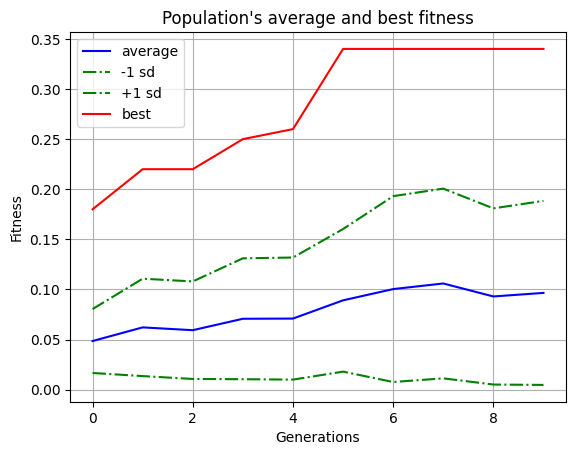

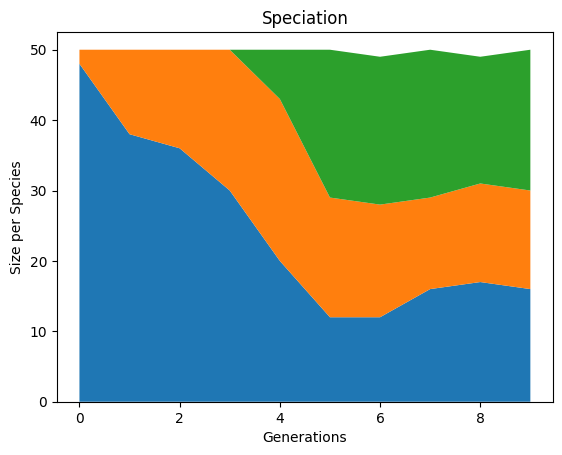

In [11]:
import neat
winner = run("coverage.config")

In [12]:
# Test the winning network
config = neat.Config(neat.DefaultGenome, neat.DefaultReproduction,
                         neat.DefaultSpeciesSet, neat.DefaultStagnation,
                         "coverage.config")
winner_net = neat.nn.FeedForwardNetwork.create(winner, config)
eval_fitness(winner_net, 60, watch=True)

0.34

During evolution, we only allowed the robot to make 60 moves when evaluating fitness.  What happens when we allow the robot to move twice as many times?

In [13]:
eval_fitness(winner_net, 120, watch=True)

0.46

What if we go three times as long?

In [14]:
eval_fitness(winner_net, 180, watch=True)

0.58

In some evolved solutions, the fitness will increase the longer you allow the robot to move.  This is a nice result, when it happens.  It indicates that evolution has discovered a good, robust solution.  